In [50]:
import cv2,os
import face_alignment
import numpy as np
import matplotlib.pyplot as plt
from skimage import io

In [63]:
_3ddfa_faceA_path = r'C:\Users\houchen\faceswap_GAN\Rotate-and-Render\3ddfa\result_faceA'
_3ddfa_faceB_path = r'C:\Users\houchen\faceswap_GAN\Rotate-and-Render\3ddfa\result_faceB'
_swp_rootpath = r'C:\Users\houchen\faceswap_GAN\img_swp'
_ori_rootpath = r'C:\Users\houchen\faceswap_GAN\img_ori'

In [54]:
def getCenter(mask):
    ##获取mask的中心点坐标
    up, down, left ,right = 0, 0, 0, 0
    up_flag, left_flag = False, False
    for i in range(len(mask)):
        for j in range(len(mask[0])):
            if mask[i][j][0] != 0:
                if not up_flag and i > up:
                    up = i
                    up_flag = True
                if i > down:  down = i
                if not left_flag and j < left:
                    left = j
                    left_flag = True
                if j > right: right = j
    return ((left+right)//2,(up+down)//2)

def listdir(path): 
    list_name = []
    for file in os.listdir(path): 
        file_path = os.path.join(path, file) 
        if os.path.isdir(file_path): 
            listdir(file_path, list_name) 
        elif os.path.splitext(file_path)[1]=='.jpg' or os.path.splitext(file_path)[1]=='.png': 
            list_name.append(file)
    return list_name

ground truth: 


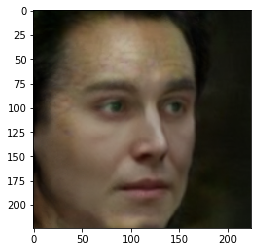

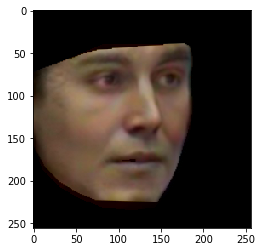

result: 


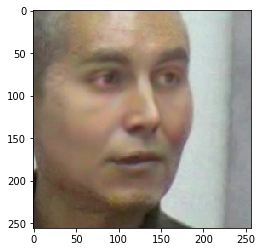

ground truth: 


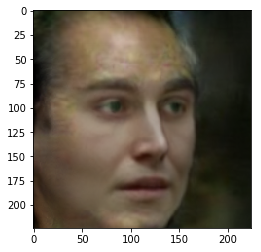

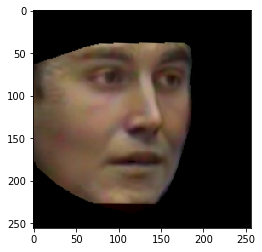

result: 


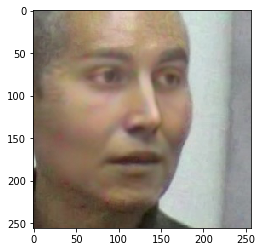

ground truth: 


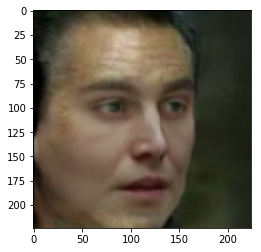

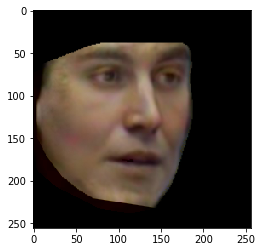

result: 


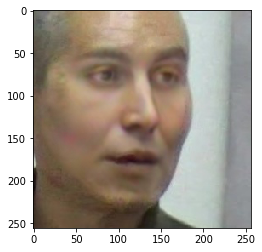

ground truth: 


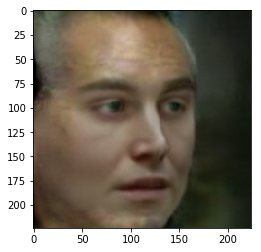

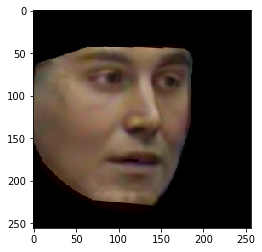

result: 


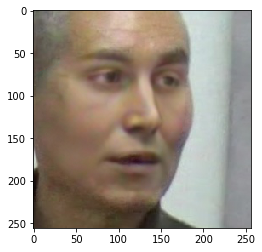

ground truth: 


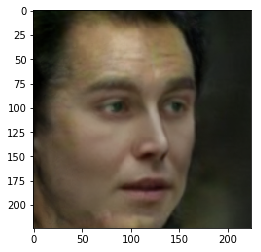

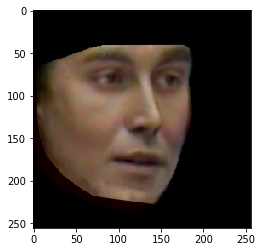

result: 


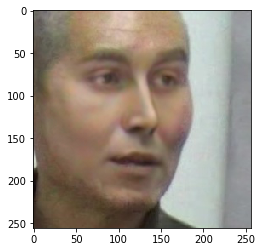

ground truth: 


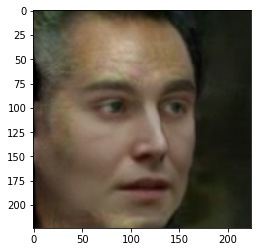

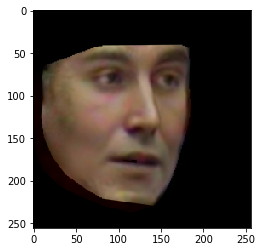

result: 


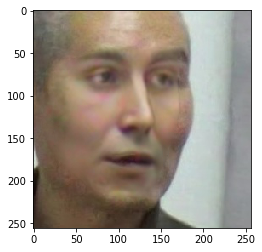

ground truth: 


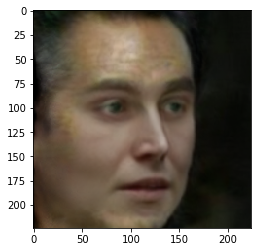

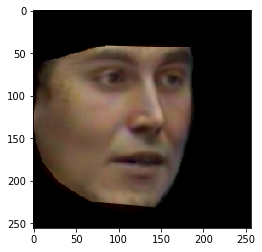

result: 


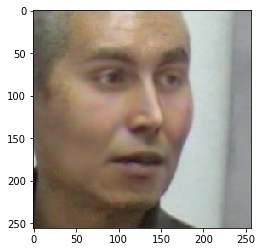

In [85]:
for swpfile in os.listdir(_swp_rootpath):
    faceA_path = os.path.join(_swp_rootpath, swpfile)
    if os.path.splitext(faceA_path)[1] != '.jpg' and os.path.splitext(faceA_path)[1] != '.png': 
        continue

    faceB_flag = False
    for orifile in os.listdir(_ori_rootpath): 
        faceB_path = os.path.join(_ori_rootpath, orifile)
        if os.path.splitext(faceB_path)[1] != '.jpg' and os.path.splitext(faceB_path)[1] != '.png': 
            continue
        elif os.path.splitext(swpfile)[0] != os.path.splitext(orifile)[0]:
            continue
        else:
            faceB_flag = True
            break
    
    dfa_faceA_flag = False
    for dfa_faceA_file in os.listdir(_3ddfa_faceA_path): 
        dfa_faceA_path = os.path.join(_3ddfa_faceA_path, dfa_faceA_file)
        if os.path.splitext(dfa_faceA_path)[1] != '.jpg' and os.path.splitext(dfa_faceA_path)[1] != '.png': 
            continue
        elif os.path.splitext(swpfile)[0] != os.path.splitext(dfa_faceA_file)[0]:
            continue
        else:
            dfa_faceA_flag = True
            break
    
    dfa_faceB_flag = False
    for dfa_faceB_file in os.listdir(_3ddfa_faceB_path): 
        dfa_faceB_path = os.path.join(_3ddfa_faceB_path, dfa_faceB_file)
        if os.path.splitext(dfa_faceB_path)[1] != '.jpg' and os.path.splitext(dfa_faceB_path)[1] != '.png': 
            continue
        elif os.path.splitext(swpfile)[0] != os.path.splitext(dfa_faceB_file)[0]:
            continue
        else:
            dfa_faceB_flag = True
            break


    if faceB_flag and dfa_faceA_flag and dfa_faceB_flag:
        #导入swp-rnr & ori
        faceA = io.imread(faceA_path)
        faceB = io.imread(faceB_path)
        #提取特征点
        fa = face_alignment.FaceAlignment(face_alignment.LandmarksType._2D, flip_input=False,device='cpu')
        landmarks_A = fa.get_landmarks(faceA)[0]
        landmarks_B = fa.get_landmarks(faceB)[0]
        #通过特征点生成mask
        kernel = np.ones((7,7),np.uint8) 
        hullA = cv2.convexHull(np.array(landmarks_A)).astype(np.int32)
        mask_fa_A = cv2.drawContours(np.zeros_like(faceA),[hullA],0,(1,1,1),-1)
        mask_fa_A = cv2.dilate(mask_fa_A,kernel)
        hullB = cv2.convexHull(np.array(landmarks_B)).astype(np.int32)
        mask_fa_B = cv2.drawContours(np.zeros_like(faceB),[hullB],0,(1,1,1),-1)
        mask_fa_B = cv2.dilate(mask_fa_B,kernel)
        #导入3ddfa生成的mask
        maskimg_rnr_A = io.imread(dfa_faceA_path)
        maskimg_rnr_B = io.imread(dfa_faceB_path)
        #将特征点生成的mask与3ddfa生成的mask取交集
        maskA = mask_fa_A
        maskB = mask_fa_B
        for i in range(len(maskA)):
            for j in range(len(maskA[0])):
                if mask_fa_A[i,j,0] == 0 or maskimg_rnr_A[i,j,0] == 0:
                    maskA[i,j] = [0,0,0]
        for i in range(len(maskB)):
            for j in range(len(maskB[0])):
                if mask_fa_B[i,j,0] == 0 or maskimg_rnr_B[i,j,0] == 0:
                    maskB[i,j] = [0,0,0]
        #求取homography matrix
        homography,_ = cv2.findHomography(landmarks_A, landmarks_B, cv2.RANSAC, ransacReprojThreshold=3.0)
        #进行face与mask的变换
        warp_faceA = cv2.warpPerspective(maskA*faceA, homography, (faceB.shape[1],faceB.shape[0]))
        warp_maskA = cv2.warpPerspective(maskA, homography, (faceB.shape[1],faceB.shape[0]))
        #颜色迁移
        yuv_faceA = cv2.cvtColor(warp_faceA,cv2.COLOR_RGB2YUV)
        yuv_faceB = cv2.cvtColor(maskB*faceB,cv2.COLOR_RGB2YUV)
        for i in range(len(yuv_faceA)):
            for j in range(len(yuv_faceA[0])):
                if maskB[i,j,0] != 0:
                    yuv_faceA[i,j,1] = yuv_faceB[i,j,1]
                    yuv_faceA[i,j,2] = yuv_faceB[i,j,2]
        col_faceA = cv2.cvtColor(yuv_faceA,cv2.COLOR_YUV2RGB)
        #泊松融合得到结果
        warp_maskA = cv2.erode(warp_maskA,kernel)
        swp_face = cv2.seamlessClone(col_faceA, faceB, 255*warp_maskA, getCenter(warp_maskA), cv2.NORMAL_CLONE)

        print('ground truth: ')
        plt.imshow(faceA)
        plt.show()
        plt.imshow(col_faceA)
        plt.show()

        print('result: ')
        plt.imshow(swp_face)
        plt.show()